# Real life calibration

In this module we employ our neural network in real calibration.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import QuantLib as ql
import time

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint

from IPython import display

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


We use the same loss functions and calibration functions as in **Module 5-Calibration Comparison**.

In [18]:
def nn_loss(x, observed_params, y_trues, net):
    n = len(y_trues)
    xs = np.array(list(x)*n).reshape(-1,5)
    nn_params = np.hstack((observed_params[:,:2], xs, observed_params[:,2:]))
    moneyness = nn_params[:,0]
    nn_params = torch.Tensor(nn_params).float().to(device)
    with torch.no_grad():
        y_preds = net(nn_params).to('cpu').detach().numpy().flatten()
    return np.mean((1/moneyness)**2*np.square(y_preds - y_trues))

def nn_res(x, observed_params, y_trues, net):
    n = len(y_trues)
    xs = np.array(list(x)*n).reshape(-1,5)
    nn_params = np.hstack((observed_params[:,:2], xs, observed_params[:,2:]))
    nn_params = torch.Tensor(nn_params).float().to(device)
    with torch.no_grad():
        y_preds = net(nn_params).to('cpu').detach().numpy().flatten()
    return y_trues,y_preds

def nn_calibration(net, observed_params, observed_price, bounds):
    res = differential_evolution(nn_loss, bounds=bounds, args=(observed_params, observed_price, net), popsize=10, polish=False, constraints=HestonUtils.feller_con)
    return res

def ql_res(x, observed_params, y_trues):
    n = len(y_trues)
    xs = np.array(list(x)*n).reshape(-1,5)
    nn_params = np.hstack((observed_params[:,:2], xs, observed_params[:,2:]))
    ql_params = HestonUtils.convertNNtoQLparams(nn_params)
    y_preds = np.array([HestonUtils.QuantlibHestonPrice(*ql_params[i]) for i in range(n)])
    return y_trues,y_preds

We now process the data.

In [4]:
dv_rates = pd.read_csv('data/calibration_dv.csv')
spots = pd.read_csv('data/calibration_spots.csv')
options = pd.read_csv('data/calibration_options.csv')

In [26]:
data = options.merge(right=dv_rates, on='date')
data = data.merge(right=spots, on='date')

print(len(data))

# some constraints
data = data[~data['symbol'].str.contains('SPXW')]
data = data[data['forward_price'] > 0]
data = data[data['best_bid'] > 0]

data['price'] = data['close']
data['strike'] = data['strike_price'] / 1000
data['moneyness'] = data['price'] / data['strike'] 
data['dv_rate'] = data['rate'] / 100
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')
data['exdate'] = pd.to_datetime(data['exdate'].astype(str), format='%Y%m%d')
data['maturity'] = (data['exdate'] - data['date']).dt.days / 365
data['rf_rate'] = np.log(data['forward_price'] / data['close']) / data['maturity'] + data['dv_rate']

data['value'] = 0.5*(data['best_bid'] + data['best_offer']) / data['strike']

data = data[abs(data['moneyness'] - 1) <= 0.5]
data = data[data['maturity'] <= 2]

print(len(data))

data = data[['moneyness', 'maturity', 'rf_rate', 'dv_rate', 'value', 'date', 'exdate', 'optionid', 'price', 'strike', 'volume', 'open_interest']]
print(data.head())

2273939
628064
    moneyness  maturity   rf_rate   dv_rate     value       date     exdate  \
34   1.497672  0.046575  0.015234  0.013943  0.497056 2018-01-02 2018-01-19   
35   1.489398  0.046575  0.015234  0.013943  0.488840 2018-01-02 2018-01-19   
36   1.481214  0.046575  0.015234  0.013943  0.480659 2018-01-02 2018-01-19   
37   1.477156  0.046575  0.015234  0.013943  0.476603 2018-01-02 2018-01-19   
38   1.473120  0.046575  0.015234  0.013943  0.472541 2018-01-02 2018-01-19   

     optionid  best_bid  best_offer    price  strike  volume  open_interest  
34  113108598     891.6       897.8  2695.81  1800.0       0             23  
35  117601453     881.7       887.9  2695.81  1810.0       0              0  
36  117601454     871.7       877.9  2695.81  1820.0       0              0  
37  113108599     866.7       872.9  2695.81  1825.0       0              1  
38  117601455     861.6       867.9  2695.81  1830.0       0              0  


We plot the spot rates of the SPX.

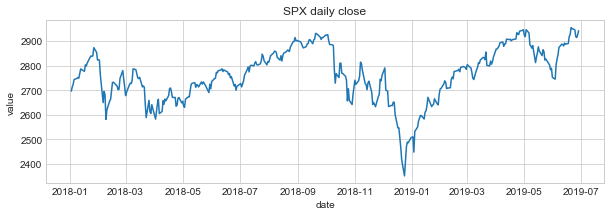

In [247]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.plot(data['date'].unique(),spots['close'])
plt.xlabel('date')
plt.ylabel('value')
plt.title('SPX daily close')
plt.savefig('SPX.pdf')
plt.show()

We now formulate a number of ways to grab a calibration set of options. We mainly focus on `findTopKOption`.

In [6]:
def findOptionGrid(data, date, **args):
    date_options = data[data['date'] == date]
    net_mats = np.sort(date_options['maturity'].unique())
    net_mons = np.sort(date_options['moneyness'].unique())
    net_mats = [net_mats[i*int(len(net_mats) / 7)] for i in range(7)]
    net_mons = [net_mons[i*int(len(net_mons) / 6)] for i in range(6)]
    date_options = date_options[date_options['maturity'].isin(net_mats)]
    date_options = date_options[date_options['moneyness'].isin(net_mons)]
    return date_options

def findTopKOption(data, date, col='volume', K=30):
    date_options = pd.DataFrame(data[data['date'] == date])
    if col == 'combined':
        date_options[col] = date_options['volume'] + date_options['open_interest']
    date_options = date_options.sort_values(by=col, ascending=False)[:K]
    return date_options

def findRandomKOption(data, date, K=30, **args):
    date_options = pd.DataFrame(data[data['date'] == date])
    date_options = date_options.sample(K)
    return date_options

We then calibrate to real data.

In [91]:
narrow_net = torch.load('models/run_133')
wide_net = torch.load('models/run_134')

class CalibrationModule:
    def __init__(self, net, data, bounds='NARROW'):
        self.net = net
        self.data = data
        self.bounds = ((0,1), (0,10), (0,1), (0,2), (-1,0))
        if bounds=='NARROW':
            self.bounds = ((0,0.5), (0,3), (0,0.5), (0,1), (-0.9,0))     
        self.x_cals = []
        self.MSEs = []
        self.test_losses = []
        self.cal_sizes = []
    
    def calibrateTimeSeries(self, method, **args):
        self.x_cals = []
        self.MSEs = []
        time_start = time.time()
        for date in self.data['date'].unique():
            cal_set = method(data, date, **args)
            
            obs_params = cal_set[['moneyness', 'maturity', 'rf_rate', 'dv_rate']].values
            obs_prices = cal_set['value'].values
            res = nn_calibration(self.net, obs_params, obs_prices, self.bounds)
            
#             test_set = findTopKOption(data, date, col='combined', K=50)
            test_set = findRandomKOption(data, date, K=30)
            test_params = test_set[['moneyness','maturity','rf_rate','dv_rate']].values
            test_prices = test_set['value'].values
            test_loss = nn_res(res.x, test_params, test_prices, self.net)
            
            self.x_cals.append(res.x)
            self.MSEs.append(res.fun)
            self.test_losses.append(test_loss)
            self.cal_sizes.append(len(cal_set))
        print(time.time()-time_start)
        

We use stored data and compare.

In [376]:
import pickle
qlres = pickle.load(open('results/real_calibration/ql.p','rb'))
narrow_30 = pickle.load(open('results/real_calibration/narrow_30.p','rb'))
wide_30 = pickle.load(open('results/real_calibration/wide_30.p','rb'))

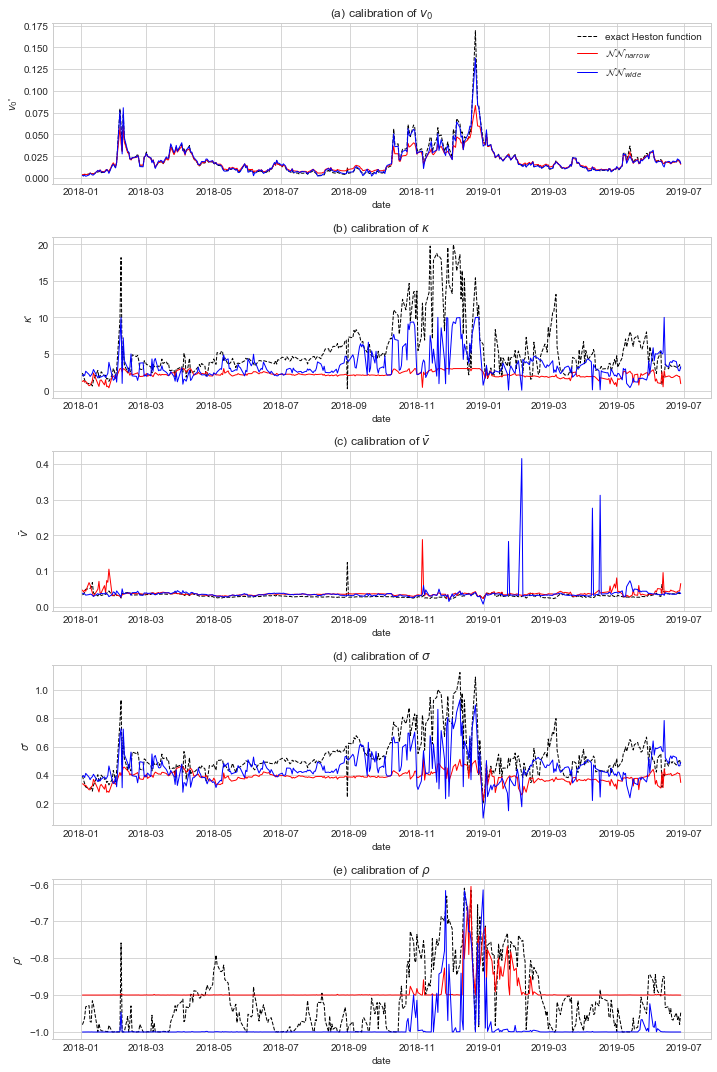

In [377]:
plt.rcParams['figure.figsize'] = [10, 15]
names = ['$v_0$', '$\kappa$', '$\\bar{v}$', '$\sigma$', '$\\rho$']
labels = ['(a)','(b)','(c)','(d)','(e)']
fig, axes = plt.subplots(5,1)
for i in range(len(axes)):
    axes[i].plot(data['date'].unique(),np.array(qlres.x_cals)[:,i], c='k',lw=1, ls='--', label='exact Heston function')
    axes[i].plot(data['date'].unique(),np.array(narrow_30.x_cals)[:,i], c='red', lw=1, label='$\mathcal{NN}_{narrow}$')
    axes[i].plot(data['date'].unique(),np.array(wide_30.x_cals)[:,i], c='blue', lw=1, label='$\mathcal{NN}_{wide}$')
    axes[i].set_xlabel('date')
    axes[i].set_ylabel(f'{names[i]}\'')
    axes[i].set_title(f'{labels[i]} calibration of {names[i]}')
axes[0].legend()
plt.tight_layout()
plt.show()

We now check errors of our desired performance metric.

In [391]:
plt.rcParams['figure.figsize'] = [10, 8]
ql_MSE = []
narrow_MSE = []
wide_MSE = []
ql_MAE = []
narrow_MAE = []
wide_MAE = []
for i in range(len(data['date'].unique())):
    date = data['date'].unique()[i]
    test_set = findTopKOption(data,date,col='combined',K=60)[30:]
    test_params = test_set[['moneyness','maturity','rf_rate','dv_rate']].values
    test_prices = test_set['value'].values
    y_trues, y_preds_narrow = nn_res(narrow_30.x_cals[i], test_params, test_prices, narrow_net)
    y_trues, y_preds_wide = nn_res(wide_30.x_cals[i], test_params, test_prices, wide_net)
#     y_trues, y_preds_narrow = ql_res(narrow_30.x_cals[i], test_params, test_prices)
#     y_trues, y_preds_wide = ql_res(wide_30.x_cals[i], test_params, test_prices)
    y_trues, y_preds_ql = ql_res(qlres.x_cals[i],test_params,test_prices)
    
    errors_ql = y_preds_ql - y_trues
    errors_narrow = y_preds_narrow - y_trues
    errors_wide = y_preds_wide - y_trues
    
    ql_MAE.append(np.mean(np.abs(errors_ql)))
    narrow_MAE.append(np.mean(np.abs(errors_narrow)))
    wide_MAE.append(np.mean(np.abs(errors_wide)))
    
    test_strikes = test_set['strike'].values
    ql_MSE.append(np.mean(np.square(test_strikes*errors_ql)))
    narrow_MSE.append(np.mean(np.square(test_strikes*errors_narrow)))
    wide_MSE.append(np.mean(np.square(test_strikes*errors_wide)))
    
    test_set['pred'] = y_preds_ql * test_set['strike']

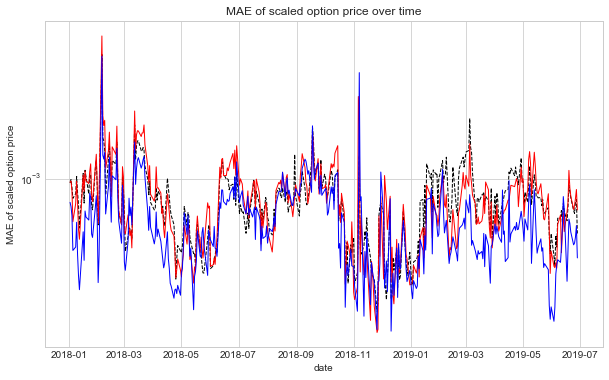

0.0008054542698210128
0.0008093988790057198
0.0006403700829770483
23
215
['2018-02-05T00:00:00.000000000' '2018-11-07T00:00:00.000000000']


In [413]:
plt.rcParams['figure.figsize'] = [10,6]
plt.semilogy(data['date'].unique(),ql_MAE, c='k', ls='--', lw=1, label='exact Heston function')
plt.plot(data['date'].unique(),narrow_MAE, c='r', lw=1, label='$\mathcal{NN}_{narrow}$')
plt.plot(data['date'].unique(),wide_MAE,c='b', lw=1, label='$\mathcal{NN}_{wide}$')
plt.xlabel('date')
plt.ylabel('MAE of scaled option price')
plt.title('MAE of scaled option price over time')
plt.show()

print(np.mean(ql_MAE))
print(np.mean(narrow_MAE))
print(np.mean(wide_MAE))

print(np.argmax(wide_MAE))
print(np.argmax(wide_MAE[50:])+50)
print(data['date'].unique()[[23,215]])

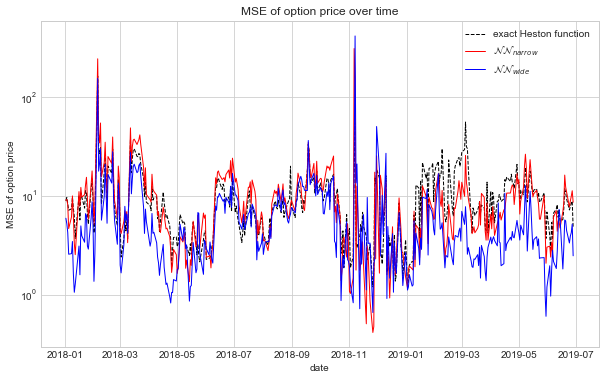

10.310826475113101
11.575528482771226
7.624079726075826


In [409]:
plt.semilogy(data['date'].unique(),ql_MSE, c='k', ls='--', lw=1, label='exact Heston function')
plt.plot(data['date'].unique(),narrow_MSE, c='r', lw=1, label='$\mathcal{NN}_{narrow}$')
plt.plot(data['date'].unique(),wide_MSE,c='b', lw=1, label='$\mathcal{NN}_{wide}$')
plt.xlabel('date')
plt.ylabel('MSE of option price')
plt.title('MSE of option price over time')
plt.legend()
plt.show()

print(np.mean(ql_MSE))
print(np.mean(narrow_MSE))
print(np.mean(wide_MSE))